In [1]:
from scipy.special import binom
from scipy.stats import poisson
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import pickle
from functools import reduce
import igraph

In [2]:
class MisinformationDistribution:
    def __init__(self, b=3, p=0.2, p0=0.8, p1=0.1, n=100, mu=2):
        assert b > 0 and 0 < p < 1 and 0 < p0 < 1 and 0 < p1 < 1 and n > 1, "The parameter's requirements are not met by the inputs."
        self.b = b
        self.mu = mu
        pb = 1 / (1 + (1 / p - 1) ** b)
        i = np.arange(n, dtype=int)

        paths = (
            binom(b + 2 * i - 1, i)
            - binom(b + 2 * i - 1, i - 1)
            - binom(b + 2 * i - 1, i - b)
            + binom(b + 2 * i - 1, i - b - 1)
            + binom(b + 2 * i - 1, i - 2 * b)
        )
        pmf1 = paths * (1 - p) ** (i) * p ** (b + i)
        pmf0 = paths * p ** (i) * (1 - p) ** (b + i)
        self.pmf = pmf0 / pmf0.sum() * (1 - pb) * (1 - p0) + pmf1 / pmf1.sum() * (pb) * (1 - p1)
        self.cdf = np.cumsum(self.pmf)
        self.compute_ecdf()
        
    def sample(self):
        rand_num = np.random.rand() 
        if rand_num > self.ecdf[-1]:
            return float("inf")
        return np.argwhere(rand_num < self.ecdf)[0][0] # + self.b
    
    def compute_ecdf(self):
        self.ecdf = np.zeros(int(self.cdf.shape[0]/self.mu))
        for t in range(self.ecdf.shape[0]):
            temp = 0
            for j in range(2*self.cdf.shape[0]):
                temp += self.cdf[j//2] * poisson.pmf(j+b, mu=self.mu*t)
            self.ecdf[t] = temp

In [3]:
def S2E(S, E, I, R, G, infection_period_distribution, beta_list=[0.5, 0.7, 0.9]):
    visited = set()
    temp_I = I.copy()
    temp_S = S.copy()
    degree = G.degree()
    for s in temp_S:
        neighbors_degree = [degree[idx.index] for idx in s.neighbors()]
        total_degree = sum(neighbors_degree)
        infection_periods = []
        for _ in range(len(neighbors_degree)):
            neighbor_select = np.random.choice(s.neighbors(), p=[x/total_degree for x in neighbors_degree])

            if neighbor_select in temp_I:
                if np.random.rand() < beta_list[neighbor_select["community"]]:
                    infection_time = infection_period_distribution.sample()
                    if infection_time != float("inf"):
                        infection_periods.append(infection_time)
        if len(infection_periods) > 0:
            E.add((s, min(infection_periods)))
            S.remove(s)
                    
    return S, E, I, R            

In [4]:
def S2I_simple(S, E, I, R, G, beta_list=[0.5, 0.7, 0.9]):
    temp_I = I.copy()
    temp_S = S.copy()
    degree = G.degree()
    for s in temp_S:
        neighbors_degree = [degree[idx.index] for idx in s.neighbors()]
        total_degree = sum(neighbors_degree)
        for _ in range(len(neighbors_degree)):
            neighbor_select = np.random.choice(s.neighbors(), p=[x/total_degree for x in neighbors_degree])
            if neighbor_select in temp_I:
                if np.random.rand() < beta_list[neighbor_select["community"]]:
                    I.add(s)
                    S.remove(s)
                    break
    
    return S, E, I, R       

In [5]:
def E2I(S, E, I, R, l=1):
    temp_E = E.copy()
    for i, t in temp_E:
        if t <= l:
            E.remove((i, t))
            I.add(i)
        else:
            E.remove((i, t))
            E.add((i, t - l))
    
    return S, E, I, R

In [6]:
def I2R(S, E, I, R, alpha_list=[0.03, 0.02, 0.01]):
    for i in I.copy():
        if np.random.rand() <= alpha_list[i["community"]]:
            I.remove(i)
            R.add(i)
            
    return S, E, I, R        

In [7]:
def I2S(S, E, I, R, alpha_list=[0.3, 0.2, 0.1]):
    temp_I = I.copy()
    for i in temp_I:
        if np.random.rand() <= alpha_list[i["community"]]:
            I.remove(i)
            S.add(i)
            
    return S, E, I, R        

In [8]:
def bmatrix(a):
    """Returns a LaTeX bmatrix
    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + '\\' if idx != len(lines) - 1 else '  ' + ' & '.join(l.split()) for idx, l in enumerate(lines)]
    rv +=  [r'\end{bmatrix}']
    return ''.join(rv)

In [9]:
title_size = 32
label_size = 28
legend_size = 22
tick_size = 18
line_width = 2
marker_size = 12
line_width_thin = 0.5

In [10]:
pref_matrix = [[0.2, 0.02, 0.02], [0.02, 0.2, 0.02], [0.02, 0.02, 0.2]]
pref_matrix = 1/2 * (np.array(pref_matrix) + np.array(pref_matrix).T) * 0.2
pref_matrix = pref_matrix.tolist()
block_sizes = [100, 100, 100] #[70, 50, 30] 
n = sum(block_sizes)
G = igraph.Graph.SBM(n, pref_matrix, block_sizes, directed=False, loops=False)
layout = G.layout()
membership = [amount*[i] for i, amount in enumerate(block_sizes)]
membership = reduce(lambda a, b: a+b, membership)
G.vs["community"] = membership


different transmission rates for three communities:  \begin{bmatrix}  0.034 & 0.171 & 0.854\end{bmatrix}
probability matrix for the SBM:  \begin{bmatrix}  0.04 & 0.004 & 0.004\  0.004 & 0.04 & 0.004\  0.004 & 0.004 & 0.04\end{bmatrix}
average degree^3: 157.86, average degree^2: 24.96


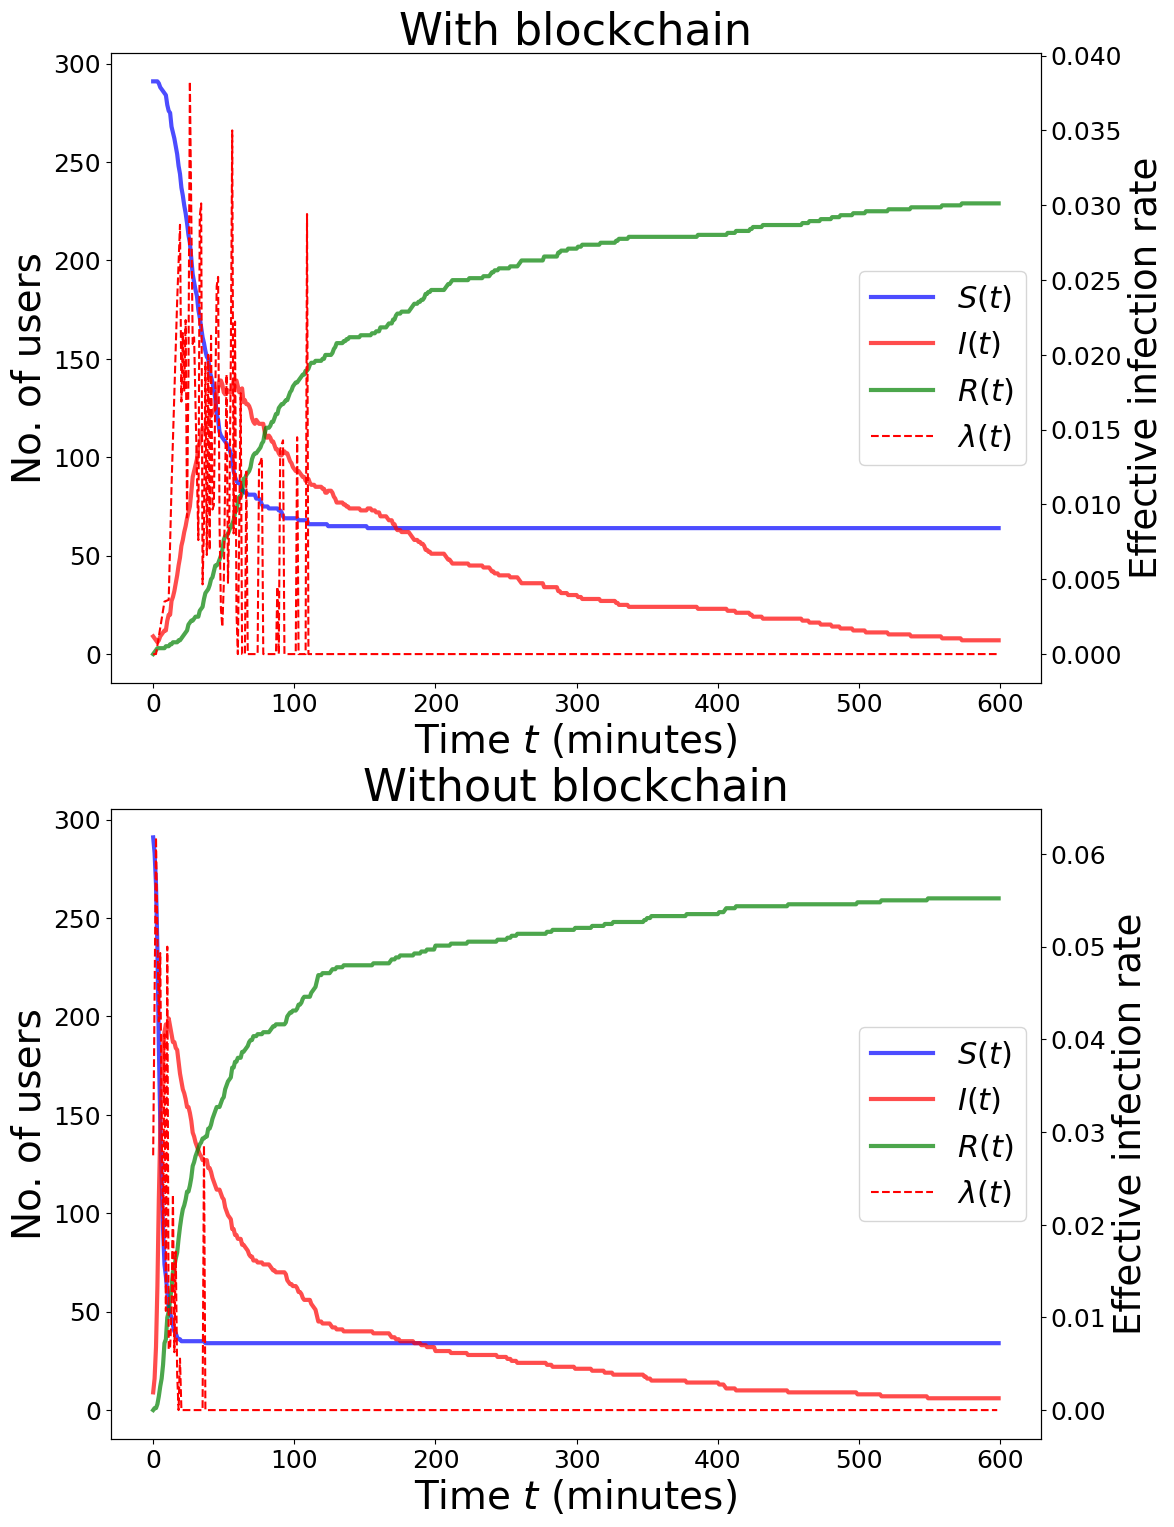

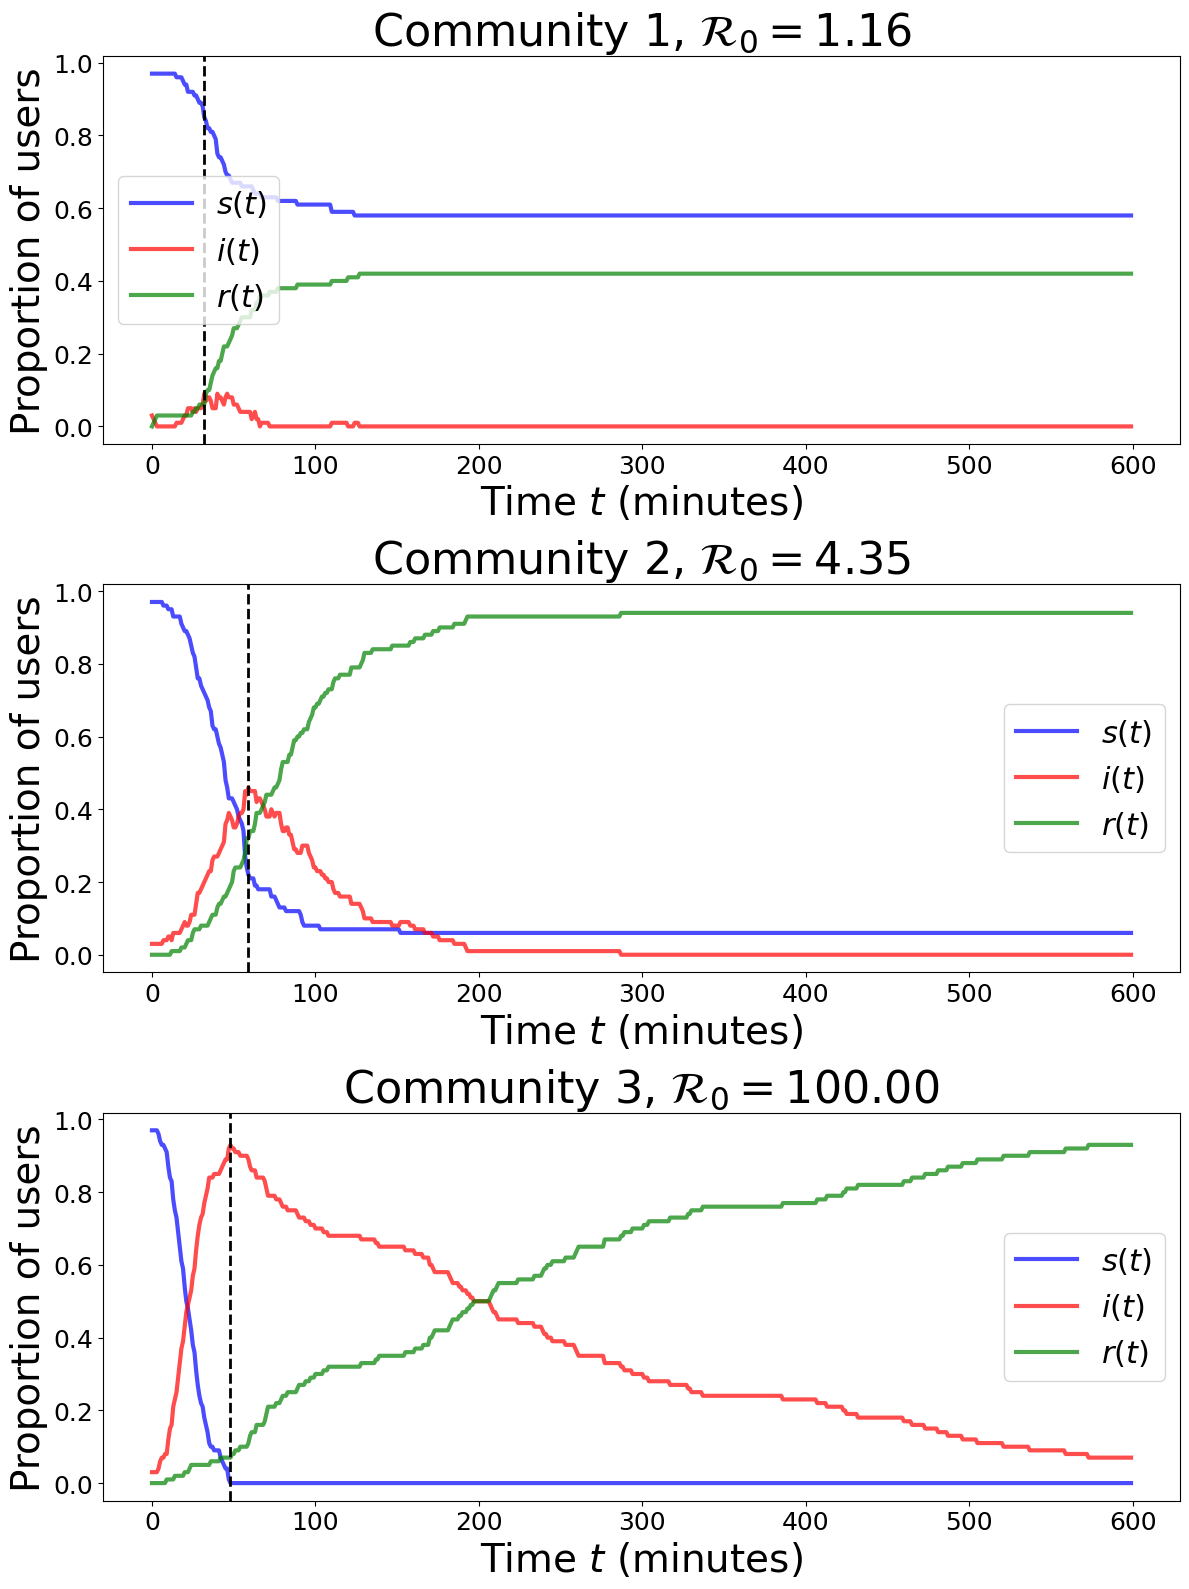

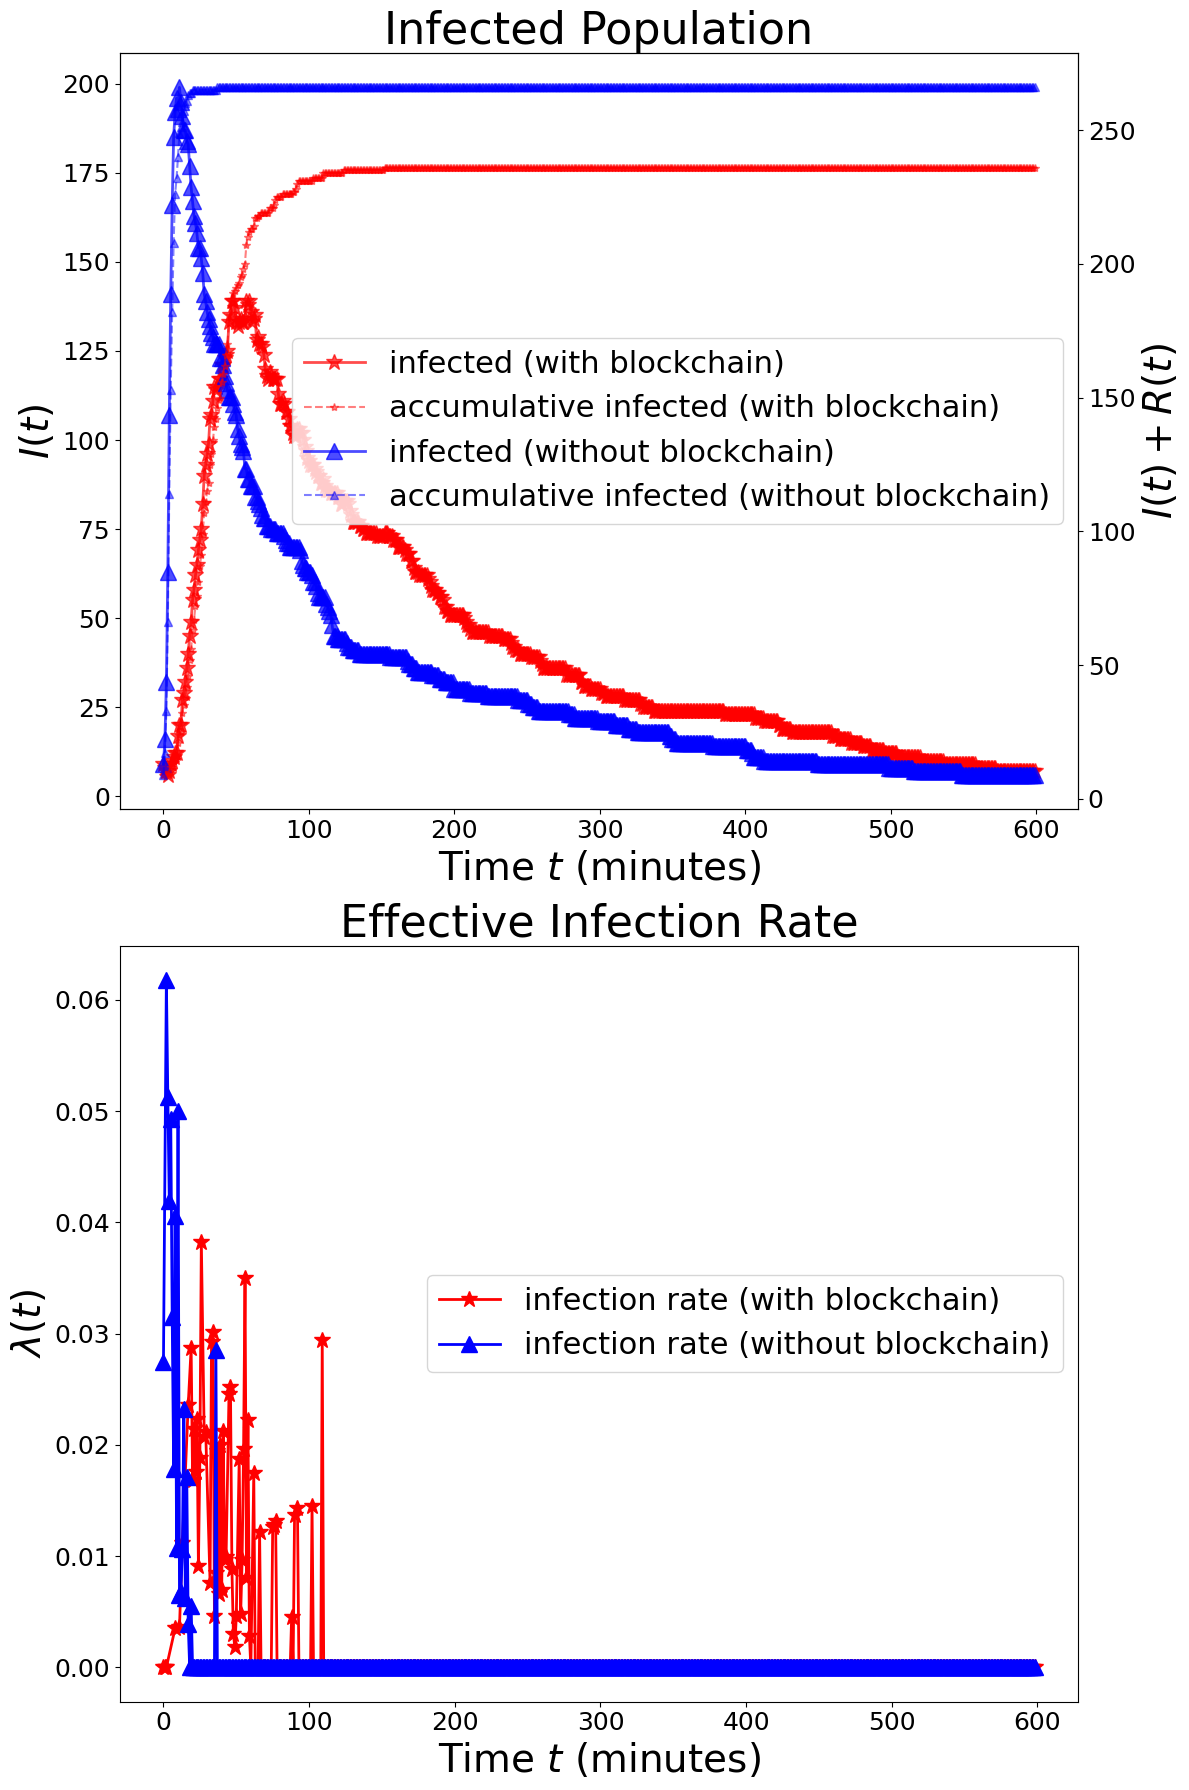

In [11]:
G.vs["infected"] = 0
G.vs["updated"] = False

v_init = np.random.choice([i for i in G.vs() if i["community"]==0], 3).tolist() + \
    np.random.choice([i for i in G.vs() if i["community"]==1], 3).tolist() + \
    np.random.choice([i for i in G.vs() if i["community"]==2], 3).tolist()

T = 600
I = set(v_init)
S = set(G.vs) - I
E = set()
R = set()

a = 0.022
b = 0.0036
alpha_list = [0.1, 0.022, 0.005]
deg = np.array(G.degree())
beta_middle = n / np.mean(deg**3) * np.mean(deg**2) * b
beta_list = [beta_middle / 5, beta_middle, beta_middle * 5]
np.set_printoptions(suppress=True)
print('different transmission rates for three communities: ', bmatrix(np.around(np.array(beta_list), 3)))
print('probability matrix for the SBM: ', bmatrix(np.around(np.array(pref_matrix), 3)))
print(f"average degree^3: {np.mean(deg**3)}, average degree^2: {np.mean(deg**2)}")

confirmation = 10
dishonest_miner_ratio = 0.3
true_if_normal = 0.8 
true_if_double_spend = 0.4
infection_period_distribution = MisinformationDistribution(b=confirmation, p=dishonest_miner_ratio, p0=true_if_normal, p1=true_if_double_spend)

S_hist = [len(S)]
I_hist = [len(I)]
E_hist = [len(E)]
R_hist = [len(R)]

I1_hist = [len([v for v in v_init if v["community"]==0])]
I2_hist = [len([v for v in v_init if v["community"]==1])]
I3_hist = [len([v for v in v_init if v["community"]==2])]
S1_hist = [block_sizes[0]-I1_hist[0]]
S2_hist = [block_sizes[1]-I2_hist[0]]
S3_hist = [block_sizes[2]-I3_hist[0]]
R1_hist = [0]
R2_hist = [0]
R3_hist = [0]
E1_hist = [0]
E2_hist = [0]
E3_hist = [0]

time = datetime.datetime.now().strftime('%m-%d %H-%M')
figname = f"b={confirmation}_p={dishonest_miner_ratio}_p0={true_if_normal}_p1={true_if_double_spend}_{time}"

for v in I:
    if not v["updated"]:
        v["updated"] = True
        v["infected"] += 1
for t in range(1, T):
    S, E, I, R = S2E(S, E, I, R, G, infection_period_distribution, beta_list)    
    S, E, I, R = E2I(S, E, I, R)
    for v in I:
        if not v["updated"]:
            v["updated"] = True
            v["infected"] += 1        

    S, E, I, R = I2R(S, E, I, R, alpha_list)
    S_hist.append(len(S))
    I_hist.append(len(I))
    R_hist.append(len(R))
    E_hist.append(len(E))
    S1_hist.append(len([v for v in S if v["community"]==0]))
    S2_hist.append(len([v for v in S if v["community"]==1]))
    S3_hist.append(len([v for v in S if v["community"]==2]))
    I1_hist.append(len([v for v in I if v["community"]==0]))
    I2_hist.append(len([v for v in I if v["community"]==1]))
    I3_hist.append(len([v for v in I if v["community"]==2]))
    R1_hist.append(len([v for v in R if v["community"]==0]))
    R2_hist.append(len([v for v in R if v["community"]==1]))
    R3_hist.append(len([v for v in R if v["community"]==2]))
    E1_hist.append(len([v for v in E if v[0]["community"]==0]))
    E2_hist.append(len([v for v in E if v[0]["community"]==1]))
    E3_hist.append(len([v for v in E if v[0]["community"]==2]))

N = sum(block_sizes)
mean_deg = igraph.mean(G.degree())
if_ratio = False
t = range(T)
S = [s+e for s, e in zip(S_hist, E_hist)]
I = I_hist 
R = R_hist

title="With blockchain"
f, ax = plt.subplots(2, 1, figsize=(12,18))
I_S_R = []
for i in t[1:]:
    dS = S[i] - S[i-1]
    dI = I[i] - I[i-1]
    dR = R[i] - R[i-1]
    if dS < 0 and S[i-1] > 0 and I[i-1] > 0:
        beta = -dS / S[i-1] / I[i-1] 
        if dR > 0:
            alpha = dR / I[i-1]
            I_S_R.append([i-1, beta/alpha])
    else:
        I_S_R.append([i-1, 0])

if if_ratio:
    ax[0].plot(t, [x/(x+y+z) for x, y, z in zip(S, I, R)], 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax[0].plot(t, [y/(x+y+z) for x, y, z in zip(S, I, R)], 'r', alpha=0.7, linewidth=2, label='Infected')
    ax[0].plot(t, [z/(x+y+z) for x, y, z in zip(S, I, R)], 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax[0].set_ylabel('Proportion of users', fontsize=16)

else:
    lns1 = ax[0].plot(t, S, 'b', alpha=0.7, linewidth=3, label=r'$S(t)$')
    lns2 = ax[0].plot(t, I, 'r', alpha=0.7, linewidth=3, label=r'$I(t)$')
    lns3 = ax[0].plot(t, R, 'g', alpha=0.7, linewidth=3, label=r'$R(t)$')
    ax[0].set_ylabel('No. of users', fontsize=label_size)

    ax2 = ax[0].twinx()
    lns4 = ax2.plot([i[0] for i in I_S_R], [i[1] for i in I_S_R], 'r--', label=r'$\lambda(t)$')

ax[0].set_title(title, fontsize=title_size)
ax[0].set_xlabel('Time $t$ (minutes)', fontsize=label_size)
ax[0].tick_params(axis='both', which='major', labelsize=tick_size)

ax2.set_ylabel('Effective infection rate', fontsize=label_size-1.3)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
legend = ax[0].legend(lns, labs, fontsize=legend_size)

fig, axes = plt.subplots(3, 1, figsize=(12,16))

argmax = I1_hist.index(max(I1_hist))
R0 = block_sizes[0]/(S1_hist[argmax] + E1_hist[argmax] + 1) 
axes[0].plot(t, [(u+x)/(u+x+y+z) for u, x, y, z in zip(S1_hist, E1_hist, I1_hist, R1_hist)], 'b', alpha=0.7, linewidth=3, label='$s(t)$')
axes[0].plot(t, [y/(u+x+y+z) for u, x, y, z in zip(S1_hist, E1_hist, I1_hist, R1_hist)], 'r', alpha=0.7, linewidth=3, label='$i(t)$')
axes[0].plot(t, [z/(u+x+y+z) for u, x, y, z in zip(S1_hist, E1_hist, I1_hist, R1_hist)], 'g', alpha=0.7, linewidth=3, label='$r(t)$')
axes[0].set_ylabel('Proportion of users', fontsize=label_size)
axes[0].set_xlabel('Time $t$ (minutes)', fontsize=label_size)
axes[0].set_title(r"Community 1, $\mathcal{{R}}_0=${:.2f}".format(R0), fontsize=title_size)
axes[0].axvline(x=argmax, linewidth=2, ls='--', color='k')
legend = axes[0].legend(fontsize=legend_size)

axes[0].tick_params(axis='both', which='major', labelsize=tick_size)

argmax = I2_hist.index(max(I2_hist))
R0 = block_sizes[1]/(S2_hist[argmax] + E2_hist[argmax] + 1)
axes[1].plot(t, [(u+x)/(u+x+y+z) for u, x, y, z in zip(S2_hist, E2_hist, I2_hist, R2_hist)], 'b', alpha=0.7, linewidth=3, label='$s(t)$')
axes[1].plot(t, [y/(u+x+y+z) for u, x, y, z in zip(S2_hist, E2_hist, I2_hist, R2_hist)], 'r', alpha=0.7, linewidth=3, label='$i(t)$')
axes[1].plot(t, [z/(u+x+y+z) for u, x, y, z in zip(S2_hist, E2_hist, I2_hist, R2_hist)], 'g', alpha=0.7, linewidth=3, label='$r(t)$')
axes[1].set_ylabel('Proportion of users', fontsize=label_size)
axes[1].set_xlabel('Time $t$ (minutes)', fontsize=label_size)
axes[1].set_title(r"Community 2, $\mathcal{{R}}_0=${:.2f}".format(R0), fontsize=title_size)
axes[1].axvline(x=argmax, linewidth=2, ls='--', color='k')
legend = axes[1].legend(fontsize=legend_size)

axes[1].tick_params(axis='both', which='major', labelsize=tick_size)

argmax = I3_hist.index(max(I3_hist))
R0 = block_sizes[2]/(S3_hist[argmax] + E3_hist[argmax] + 1)
axes[2].plot(t, [(u+x)/(u+x+y+z) for u, x, y, z in zip(S3_hist, E3_hist, I3_hist, R3_hist)], 'b', alpha=0.7, linewidth=3, label='$s(t)$')
axes[2].plot(t, [y/(u+x+y+z) for u, x, y, z in zip(S3_hist, E3_hist, I3_hist, R3_hist)], 'r', alpha=0.7, linewidth=3, label='$i(t)$')
axes[2].plot(t, [z/(u+x+y+z) for u, x, y, z in zip(S3_hist, E3_hist, I3_hist, R3_hist)], 'g', alpha=0.7, linewidth=3, label='$r(t)$')
axes[2].set_ylabel('Proportion of users', fontsize=label_size)
axes[2].set_xlabel('Time $t$ (minutes)', fontsize=label_size)
axes[2].set_title(r"Community 3, $\mathcal{{R}}_0=${:.2f}".format(R0), fontsize=title_size)
axes[2].axvline(x=argmax, linewidth=2, ls='--', color='k')
legend = axes[2].legend(fontsize=legend_size)

axes[2].tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
fig.savefig('community {:}.png'.format(figname), dpi=100)

f4, ax4 = plt.subplots(2, 1, figsize=(12,18))
title1 = r'Infected Population'
title2 = r'Effective Infection Rate'
I_S_R = []
for i in t[1:]:
    dS = S[i] - S[i-1]
    dI = I[i] - I[i-1]
    dR = R[i] - R[i-1]
    if dS < 0 and S[i-1] > 0 and I[i-1] > 0:
        beta = -dS / S[i-1] / I[i-1] 
        if dR > 0:
            alpha = dR / I[i-1]
            I_S_R.append([i-1, beta/alpha])
    else:
        I_S_R.append([i-1, 0])

if if_ratio:
    ax4[0].plot(t, [x/(x+y+z) for x, y, z in zip(S, I, R)], 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax4[0].plot(t, [y/(x+y+z) for x, y, z in zip(S, I, R)], 'r', alpha=0.7, linewidth=2, label='Infected')
    ax4[0].plot(t, [z/(x+y+z) for x, y, z in zip(S, I, R)], 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax4[0].set_ylabel('Proportion of users', fontsize=16)

else:

    lns_inf1 = ax4[0].plot(t, I, 'r*-', alpha=0.7, linewidth=line_width, markersize=marker_size, label=r'infected (with blockchain)')

    ax4[0].set_ylabel('No. of users', fontsize=label_size)

    lns4 = ax4[1].plot([i[0] for i in I_S_R], [i[1] for i in I_S_R], 'r*-', linewidth=line_width, markersize=marker_size, label=r'infection rate (with blockchain)')

    ax4_2 = ax4[0].twinx()
    lns_inf2 = ax4_2.plot(t, [i+r for i, r in zip(I, R)], 'r*--', alpha=0.5, label=r'accumulative infected (with blockchain)')

ax4[0].set_title(title1, fontsize=title_size)
ax4[0].set_xlabel('Time $t$ (minutes)', fontsize=label_size)    
ax4[0].tick_params(axis='both', which='major', labelsize=tick_size)

ax4[1].set_ylabel('Effective infection rate', fontsize=label_size-1.3)

ax4[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax4[1].set_title(title2, fontsize=title_size)

G.vs["infected"] = 0
G.vs["updated"] = False

I = set(v_init)
S = set(G.vs) - I
E = set()
R = set()

S_hist = [len(S)]
I_hist = [len(I)]
E_hist = [len(E)]
R_hist = [len(R)]

I1_hist = [len([v for v in v_init if v["community"]==0])]
I2_hist = [len([v for v in v_init if v["community"]==1])]
I3_hist = [len([v for v in v_init if v["community"]==2])]
S1_hist = [block_sizes[0]-I1_hist[0]]
S2_hist = [block_sizes[1]-I2_hist[0]]
S3_hist = [block_sizes[2]-I3_hist[0]]
R1_hist = [0]
R2_hist = [0]
R3_hist = [0]
E1_hist = [0]
E2_hist = [0]
E3_hist = [0]

for v in I:
    if not v["updated"]:
        v["updated"] = True
        v["infected"] += 1
for t in range(1, T):
    S, E, I, R = S2I_simple(S, E, I, R, G, beta_list)    
    for v in I:
        if not v["updated"]:
            v["updated"] = True
            v["infected"] += 1        

    S, E, I, R = I2R(S, E, I, R, alpha_list)
    S_hist.append(len(S))
    I_hist.append(len(I))
    R_hist.append(len(R))
    E_hist.append(len(E))
    S1_hist.append(len([v for v in S if v["community"]==0]))
    S2_hist.append(len([v for v in S if v["community"]==1]))
    S3_hist.append(len([v for v in S if v["community"]==2]))
    I1_hist.append(len([v for v in I if v["community"]==0]))
    I2_hist.append(len([v for v in I if v["community"]==1]))
    I3_hist.append(len([v for v in I if v["community"]==2]))
    R1_hist.append(len([v for v in R if v["community"]==0]))
    R2_hist.append(len([v for v in R if v["community"]==1]))
    R3_hist.append(len([v for v in R if v["community"]==2]))
    E1_hist.append(len([v for v in E if v[0]["community"]==0]))
    E2_hist.append(len([v for v in E if v[0]["community"]==1]))
    E3_hist.append(len([v for v in E if v[0]["community"]==2]))    

t = range(T)
S = [s+e for s, e in zip(S_hist, E_hist)]
I = I_hist 
R = R_hist

title="Without blockchain"
I_S_R = []
for i in t[1:]:
    dS = S[i] - S[i-1]
    dI = I[i] - I[i-1]
    dR = R[i] - R[i-1]
    if dS < 0 and S[i-1] > 0 and I[i-1] > 0:
        beta =  -dS / S[i-1] / I[i-1] 
        if dR > 0:
            alpha = dR / I[i-1]
            I_S_R.append([i-1, beta/alpha])
    else:
        I_S_R.append([i-1, 0])

if if_ratio:
    ax[1].plot(t, [x/(x+y+z) for x, y, z in zip(S, I, R)], 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax[1].plot(t, [y/(x+y+z) for x, y, z in zip(S, I, R)], 'r', alpha=0.7, linewidth=2, label='Infected')
    ax[1].plot(t, [z/(x+y+z) for x, y, z in zip(S, I, R)], 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax[1].set_ylabel('Proportion of users', fontsize=16)

else:
    lns1 = ax[1].plot(t, S, 'b', alpha=0.7, linewidth=3, label=r'$S(t)$')

    lns2 = ax[1].plot(t, I, 'r', alpha=0.7, linewidth=3, label=r'$I(t)$')
    lns3 = ax[1].plot(t, R, 'g', alpha=0.7, linewidth=3, label=r'$R(t)$')
    ax[1].set_ylabel('No. of users', fontsize=label_size)

    ax2 = ax[1].twinx()
    lns4 = ax2.plot([i[0] for i in I_S_R], [i[1] for i in I_S_R], 'r--', label=r'$\lambda(t)$')

ax[1].set_title(title, fontsize=title_size)
ax[1].set_xlabel('Time $t$ (minutes)', fontsize=label_size)    
ax[1].tick_params(axis='both', which='major', labelsize=tick_size)

ax2.set_ylabel('Effective infection rate', fontsize=label_size-1.3)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
legend = ax[1].legend(lns, labs, fontsize=legend_size)

plt.tight_layout()    

if if_ratio:
    ax4[0].plot(t, [x/(x+y+z) for x, y, z in zip(S, I, R)], 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax4[0].plot(t, [y/(x+y+z) for x, y, z in zip(S, I, R)], 'r', alpha=0.7, linewidth=2, label='Infected')
    ax4[0].plot(t, [z/(x+y+z) for x, y, z in zip(S, I, R)], 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax4[0].set_ylabel('Proportion of users', fontsize=16)

else:
    lns_inf3 = ax4[0].plot(t, I, 'b^-', alpha=0.7, linewidth=line_width, markersize=marker_size, label=r'infected (without blockchain)')
    ax4[0].set_ylabel(r'$I(t)$', fontsize=label_size)

    lns4 = ax4[1].plot([i[0] for i in I_S_R], [i[1] for i in I_S_R], 'b^-', linewidth=line_width, markersize=marker_size, label=r'infection rate (without blockchain)')

    lns_inf4 = ax4_2.plot(t, [i+r for i, r in zip(I, R)], 'b^--', alpha=0.5, label=r'accumulative infected (without blockchain)')
    ax4_2.set_ylabel(r'$I(t)+R(t)$', fontsize=label_size)

    ax4_2.tick_params(axis='both', which='major', labelsize=tick_size)

ax4[0].set_title(title1, fontsize=title_size)
ax4[0].set_xlabel('Time $t$ (minutes)', fontsize=label_size)    
ax4[0].tick_params(axis='both', which='major', labelsize=tick_size)

ax4[1].set_xlabel('Time $t$ (minutes)', fontsize=label_size)
ax4[1].set_ylabel(r'$\lambda(t)$', fontsize=label_size)

ax4[1].tick_params(axis='both', which='major', labelsize=tick_size)
ax4[1].set_title(title2, fontsize=title_size)
legend = ax4[1].legend(fontsize=legend_size, loc='center right')

lns = lns_inf1+lns_inf2+lns_inf3+lns_inf4
labs = [l.get_label() for l in lns]
legend = ax4[0].legend(lns, labs, fontsize=legend_size, loc='center right')

plt.tight_layout()
f4.savefig('blockchain new {:}.png'.format(figname), dpi=100)

In [12]:
def compute_R0(p0, p1, G, v_init):
    T = 600
    I = set(v_init)
    S = set(G.vs) - I
    E = set()
    R = set()

    ## define different transmission rate for three communities
    a = 0.022
    b = 0.0036
    alpha_list = [0.1, 0.022, 0.005]
    deg = np.array(G.degree())
    beta_middle = n / np.mean(deg**3) * np.mean(deg**2) * b
    beta_list = [beta_middle / 5, beta_middle, beta_middle * 5]

    confirmation = 10
    dishonest_miner_ratio = 0.3
    true_if_normal = p0 #0.8 
    true_if_double_spend = p1 #0.4
    infection_period_distribution = MisinformationDistribution(b=confirmation, p=dishonest_miner_ratio, p0=true_if_normal, p1=true_if_double_spend)

    S_hist = [len(S)]
    I_hist = [len(I)]
    E_hist = [len(E)]
    R_hist = [len(R)]

    I1_hist = [len([v for v in v_init if v["community"]==0])]
    I2_hist = [len([v for v in v_init if v["community"]==1])]
    I3_hist = [len([v for v in v_init if v["community"]==2])]
    S1_hist = [block_sizes[0]-I1_hist[0]]
    S2_hist = [block_sizes[1]-I2_hist[0]]
    S3_hist = [block_sizes[2]-I3_hist[0]]
    R1_hist = [0]
    R2_hist = [0]
    R3_hist = [0]
    E1_hist = [0]
    E2_hist = [0]
    E3_hist = [0]

    ## discrete time simulation
    time = datetime.datetime.now().strftime('%m-%d %H-%M')
    figname = f"b={confirmation}_p={dishonest_miner_ratio}_p0={true_if_normal}_p1={true_if_double_spend}_{time}"

    for v in I:
        if not v["updated"]:
            v["updated"] = True
            v["infected"] += 1
    for t in range(1, T):
        S, E, I, R = S2E(S, E, I, R, G, infection_period_distribution, beta_list)    
        S, E, I, R = E2I(S, E, I, R)
        for v in I:
            if not v["updated"]:
                v["updated"] = True
                v["infected"] += 1        

        S, E, I, R = I2R(S, E, I, R, alpha_list)
        S_hist.append(len(S))
        I_hist.append(len(I))
        R_hist.append(len(R))
        E_hist.append(len(E))
        S1_hist.append(len([v for v in S if v["community"]==0]))
        S2_hist.append(len([v for v in S if v["community"]==1]))
        S3_hist.append(len([v for v in S if v["community"]==2]))
        I1_hist.append(len([v for v in I if v["community"]==0]))
        I2_hist.append(len([v for v in I if v["community"]==1]))
        I3_hist.append(len([v for v in I if v["community"]==2]))
        R1_hist.append(len([v for v in R if v["community"]==0]))
        R2_hist.append(len([v for v in R if v["community"]==1]))
        R3_hist.append(len([v for v in R if v["community"]==2]))
        E1_hist.append(len([v for v in E if v[0]["community"]==0]))
        E2_hist.append(len([v for v in E if v[0]["community"]==1]))
        E3_hist.append(len([v for v in E if v[0]["community"]==2]))


    # fig, ax = plotsir(range(T), S_hist, I_hist, R_hist, title="With blockchain")
    N = sum(block_sizes)
    mean_deg = igraph.mean(G.degree())
    if_ratio = False
    t = range(T)
    S = [s+e for s, e in zip(S_hist, E_hist)]
    I = I_hist 
    R = R_hist



    argmax = I_hist.index(max(I_hist))
    R0 = N/(S_hist[argmax] + E_hist[argmax] + 1) # when computing R0, add one to avoid dividing by zero
    # axes[0].plot(t, [(u+x)/(u+x+y+z) for u, x, y, z in zip(S1_hist, E1_hist, I1_hist, R1_hist)], 'b', alpha=0.7, linewidth=3, label='$s(t)$')
    # axes[0].plot(t, [y/(u+x+y+z) for u, x, y, z in zip(S1_hist, E1_hist, I1_hist, R1_hist)], 'r', alpha=0.7, linewidth=3, label='$i(t)$')
    # axes[0].plot(t, [z/(u+x+y+z) for u, x, y, z in zip(S1_hist, E1_hist, I1_hist, R1_hist)], 'g', alpha=0.7, linewidth=3, label='$r(t)$')
    # axes[0].set_ylabel('Proportion of users', fontsize=label_size)
    # axes[0].set_xlabel('Time $t$ (minutes)', fontsize=label_size)
    # axes[0].set_title(r"Community 1, $\mathcal{{R}}_0=${:.2f}".format(R0), fontsize=title_size)
    # axes[0].axvline(x=argmax, linewidth=2, ls='--', color='k')
    # legend = axes[0].legend(fontsize=legend_size)
    # # legend.get_frame().set_alpha(0.5)
    # axes[0].tick_params(axis='both', which='major', labelsize=tick_size)
    # plt.tight_layout()
    # fig.savefig('community {:}.png'.format(figname), dpi=100)
    
    return R0


In [13]:
G.vs["infected"] = 0
G.vs["updated"] = False
## initialize population 
v_init = np.random.choice([i for i in G.vs() if i["community"]==0], 3).tolist() + \
    np.random.choice([i for i in G.vs() if i["community"]==1], 3).tolist() + \
    np.random.choice([i for i in G.vs() if i["community"]==2], 3).tolist()

R0_mat = np.zeros((10, 10), dtype=float)
p0_list = np.linspace(0.1, 0.9, 10)
p1_list = np.linspace(0.1, 0.9, 10)
num_trials = 10
p0_mat, p1_mat = np.meshgrid(p0_list, p1_list, indexing='ij')
for p0_idx in range(10):
    for p1_idx in range(10):
        result = np.zeros(num_trials)
        for trial_idx in range(num_trials):
            result[trial_idx] = compute_R0(p0_mat[p0_idx, p1_idx], p1_mat[p0_idx, p1_idx], G, v_init)
        R0_mat[p0_idx, p1_idx] = np.mean(result) 

KeyboardInterrupt: 

In [ ]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
cax = ax.matshow(R0_mat)
ax.set_ylabel(r"$p_0$", fontsize=16)
ax.set_xlabel(r"$p_1$", fontsize=16)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=10)
ax.set_yticklabels([''] + FormatStrFormatter('%.2f').format_ticks(p0_list[::1].tolist()))
ax.set_xticklabels([''] + FormatStrFormatter('%.2f').format_ticks(p1_list[::1].tolist()))
cbar = fig.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$R_0$", fontsize=16, rotation=0)
plt.tight_layout()
fig.savefig('R0.png', bbox_inches="tight", dpi=100)